In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Inspect
inspector = inspect(engine)
inspector.get_table_names()

#Get column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()


('2017-08-23',)

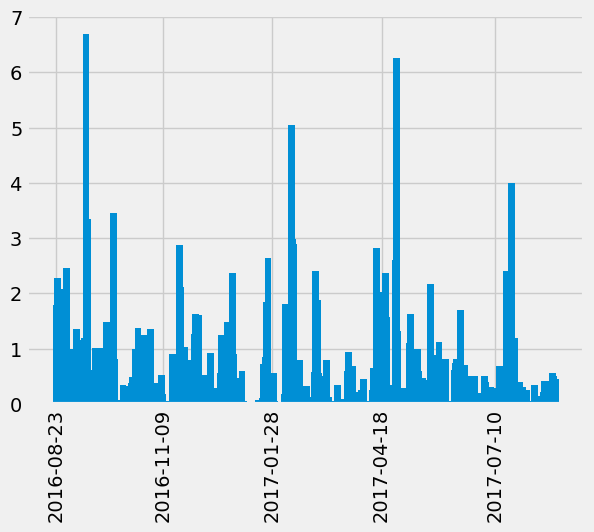

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23)-dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
measure = session.query(Measurement).\
    filter(Measurement.date >= year_ago).\
    order_by(Measurement.date).all()

    
# Save the query results as a Pandas DataFrame. Explicitly set the column names
dates=[]
prcps = []
for row in measure:
    dates.append(row.date)
    prcps.append(row.prcp)
measure_df = pd.DataFrame({"Date": dates, "Precipitation": prcps})

#Drop null values
measure_df_2 = measure_df.dropna()
dates_2 = measure_df_2["Date"]
prcps_2 = measure_df_2["Precipitation"]

measure_df_2.head(50)

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = np.arange(len(dates_2))
plt.bar(dates_2, prcps_2, width = 5)
plt.xticks(["2016-08-23", "2016-11-09", '2017-01-28', '2017-04-18', "2017-07-10"], rotation=90)
plt.show()
#measure_df

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
measure_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Inspect
inspector = inspect(engine)
inspector.get_table_names()

#Get column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.station).count()

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_query = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
all_values = session.query (func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()

all_values

[(54.0, 85.0, 71.66378066378067)]

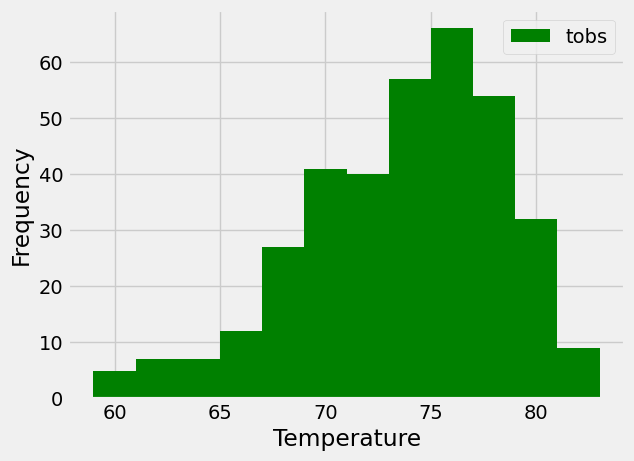

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Find last date
session.query(Measurement.date).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date.desc()).first()

temp_year_ago = dt.date(2017, 8, 18)-dt.timedelta(days=365)

#Query year ago
year_ago_temps = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= temp_year_ago).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()

#Make new lists to store dates and temps
new_temps = []
new_dates = []
for temp in year_ago_temps:
    new_dates.append(temp.date)
    new_temps.append(temp.tobs)

#New data frame from lists
temps_df = pd.DataFrame({"Date": new_dates, "Temperatures": new_temps})
temps_df

#Plot using Pandas
plt.hist(new_temps, color = "green", bins = 12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.show()

# Close Session

In [18]:
# Close Session
session.close()